In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

from helper import get_theoretical_normal_displacement, get_theoretical_contact_radius
from contact_mechanics_internodes import *

## 3D sphere

In [3]:
# Set up contact problem
mesh_file = 'mesh/contact3d_sphere.msh'
material_file = 'material/material.dat'
spatial_dimension = 3
aka.parseInput(material_file)

mesh = aka.Mesh(spatial_dimension)
mesh.read(mesh_file)

model = aka.SolidMechanicsModel(mesh)
model.initFull(_analysis_method=aka._implicit_dynamic)

# Apply boundary conditions
model.applyBC(aka.FixedValue(0., aka._x), 'primary_fixed')
model.applyBC(aka.FixedValue(0., aka._y), 'primary_fixed')
model.applyBC(aka.FixedValue(0., aka._z), 'primary_fixed')
model.applyBC(aka.FixedValue(0., aka._x), 'secondary_fixed')
model.applyBC(aka.FixedValue(-0.1, aka._y), 'secondary_fixed')
model.applyBC(aka.FixedValue(0., aka._z), 'secondary_fixed')

# Run internodes algorithm
d0 = 0.05
R = 0.5

E = model.getMaterial(0).getReal("E")
nu = model.getMaterial(0).getReal("nu")

d_list = np.linspace(0.05, 0.35, 10)
a_list = np.empty_like(d_list)
u_list = np.empty_like(d_list)

for j, d in enumerate(d_list):

    model.applyBC(aka.FixedValue(-d+d0, aka._y), 'secondary_fixed')

    # Get positions of all nodes, surface connectivity and candidate nodes
    positions = mesh.getNodes()
    surface_connectivity = mesh.getConnectivity(aka._triangle_3)
    nodes_candidate_primary = mesh.getElementGroup('primary_candidates').getNodeGroup().getNodes().ravel()
    nodes_candidate_secondary = mesh.getElementGroup('secondary_candidates').getNodeGroup().getNodes().ravel()

    # Set initial conditions
    internodes_model = ContactMechanicsInternodes(spatial_dimension, model, positions, surface_connectivity, nodes_candidate_primary, nodes_candidate_secondary)

    max_iter = 10
    for i in range(max_iter):
        # Find the interface nodes
        internodes_model.find_interface_nodes()

        # Assemble model
        internodes_model.assemble_full_model()

        # Solve model
        displacements, lambdas = internodes_model.solve_direct()

        # Update the interface nodes and check if it converged
        converged = internodes_model.update_interface(displacements, lambdas)

        if converged:
            break

    assert i+1 < max_iter

    positions = internodes_model.nodal_positions + displacements
    positions_interface_secondary = positions[internodes_model.nodes_interface_secondary]

    a_list[j] = np.max(sp.spatial.distance.cdist(positions_interface_secondary, positions_interface_secondary))/2
    u_list[j] = np.min(positions_interface_secondary[:, 1])


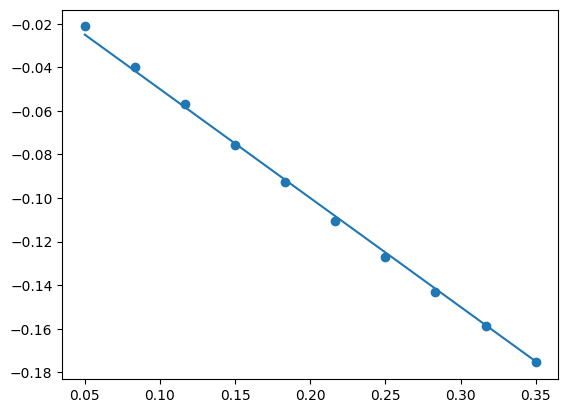

In [4]:
plt.scatter(d_list, u_list)
plt.plot(d_list, get_theoretical_normal_displacement(R, d_list, E, nu))

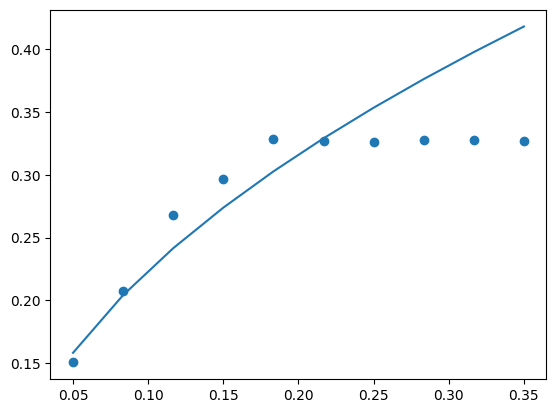

In [5]:
plt.scatter(d_list, a_list)
plt.plot(d_list, get_theoretical_contact_radius(R, d_list))

## 2D circle

In [6]:
# Set up contact problem
mesh_file = 'mesh/contact2d_circle.msh'
material_file = 'material/material.dat'
spatial_dimension = 2
aka.parseInput(material_file)

mesh = aka.Mesh(spatial_dimension)
mesh.read(mesh_file)

model = aka.SolidMechanicsModel(mesh)
model.initFull(_analysis_method=aka._implicit_dynamic)

# Apply boundary conditions
model.applyBC(aka.FixedValue(0., aka._x), 'primary_fixed')
model.applyBC(aka.FixedValue(0., aka._y), 'primary_fixed')
model.applyBC(aka.FixedValue(0., aka._x), 'secondary_fixed')
model.applyBC(aka.FixedValue(-0.1, aka._y), 'secondary_fixed')

# Run internodes algorithm
d0 = 0.05
R = 0.5

E = model.getMaterial(0).getReal("E")
nu = model.getMaterial(0).getReal("nu")

d_list = np.linspace(0.05, 0.35, 10)
a_list = np.empty_like(d_list)
u_list = np.empty_like(d_list)

for j, d in enumerate(d_list):

    model.applyBC(aka.FixedValue(-d+d0, aka._y), 'secondary_fixed')

    # Get positions of all nodes, surface connectivity and candidate nodes
    positions = mesh.getNodes()
    surface_connectivity = mesh.getConnectivity(aka._segment_2)
    nodes_candidate_primary = mesh.getElementGroup('primary_candidates').getNodeGroup().getNodes().ravel()
    nodes_candidate_secondary = mesh.getElementGroup('secondary_candidates').getNodeGroup().getNodes().ravel()

    # Set initial conditions
    internodes_model = ContactMechanicsInternodes(spatial_dimension, model, positions, surface_connectivity, nodes_candidate_primary, nodes_candidate_secondary)

    max_iter = 10
    for i in range(max_iter):
        # Find the interface nodes
        internodes_model.find_interface_nodes()

        # Assemble model
        internodes_model.assemble_full_model()

        # Solve model
        displacements, lambdas = internodes_model.solve_direct()

        # Update the interface nodes and check if it converged
        converged = internodes_model.update_interface(displacements, lambdas)

        if converged:
            break

    assert i+1 < max_iter

    positions = internodes_model.nodal_positions + displacements
    positions_interface_secondary = positions[internodes_model.nodes_interface_secondary]

    a_list[j] = np.max(sp.spatial.distance.cdist(positions_interface_secondary, positions_interface_secondary))/2
    u_list[j] = np.min(positions_interface_secondary[:, 1])


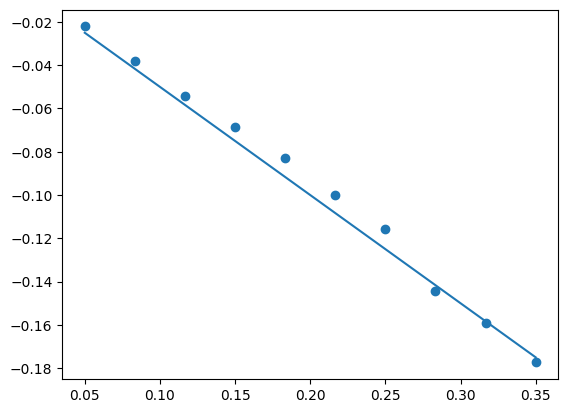

In [7]:
plt.scatter(d_list, u_list)
plt.plot(d_list, get_theoretical_normal_displacement(R, d_list, E, nu))

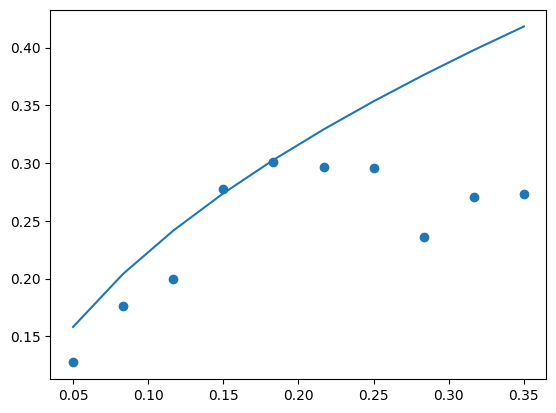

In [8]:
plt.scatter(d_list, a_list)
plt.plot(d_list, get_theoretical_contact_radius(R, d_list))